In [1]:
# ! pip install imbalanced-learn
import pandas as pd
import sklearn
import numpy as np


In [2]:
df = pd.read_csv("../../data/processed/cleaned_data.csv",dtype="category")
df.head()

,Route Type,Collision Type,Weather,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Driver At Fault,Injury Severity,Driver Distracted By,Speed Limit,Day of Week,Time of Day
0,County,OTHER,CLEAR,DRY,DAYLIGHT,NO CONTROLS,DETECTED,Yes,No Injury,NOT DISTRACTED,15-25,Sunday,afternoon
1,County,OTHER,CLOUDY,DRY,DAYLIGHT,NO CONTROLS,NONE DETECTED,Yes,Minor Injury,NOT DISTRACTED,15-25,Monday,morning
2,Municipality,SAME DIR REAR END,CLEAR,DRY,DAWN,TRAFFIC SIGNAL,NONE DETECTED,No,No Injury,NOT DISTRACTED,30-40,Tuesday,morning
3,County,SINGLE VEHICLE,CLOUDY,DRY,DAYLIGHT,NO CONTROLS,NONE DETECTED,No,No Injury,NOT DISTRACTED,30-40,Tuesday,morning
4,County,SINGLE VEHICLE,CLEAR,DRY,DARK LIGHTS ON,NO CONTROLS,DETECTED,No,No Injury,NOT DISTRACTED,30-40,Thursday,dawn


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier



In [4]:
# Due to the nature of traffic accidents, 
# the class attribute is significantly imbalanced as you can see from the output below.
df["Injury Severity"].value_counts()

# This is why balance class attribute is needed in the next code block. 

No Injury         84376
Minor Injury      19981
Serious Injury     1022
Name: Injury Severity, dtype: int64

In [3]:
# balance class attribute data
from sklearn.datasets import make_classification

# separate class attribute out before balance
y=df["Injury Severity"]
x=df.drop(["Injury Severity"],axis=1)
nrow=df.shape[0]
ncol=df.shape[1]


class_distribution = df["Injury Severity"].value_counts().to_list()

total= sum(class_distribution)

class_weights = {0: class_distribution[0]/total,
                 1: class_distribution[1]/total,
                 2: class_distribution[2]/total}

# before conducting ROSE or SMOTE, we need to create a synthetic classification dataset with controlled characteristics. 
x, y = make_classification(
    n_samples=nrow,  # the number of rows in clean dataset
    n_features=ncol-1,  # Total number of features excluding the class attribute
    n_informative=ncol-1,  # Number of informative features in your dataset
    n_redundant=0,  # Number of redundant features 
    n_repeated=0,  # Number of repeated features 
    n_classes=3,  # Number of classes in class attribute
    weights=class_weights,  # Class distribution of the target variable
    random_state=42)

print("Generated class distribution:")
print(np.bincount(y))

# if you need to split data into 20% test set and 80% training set.
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Generated class distribution:
[83894 20148  1337]


In [4]:
# SMOTE(Synthetic Minority Over-sampling Technique)
# this is a popular technique used to address class imbalance in classification  
# it's designed to handle the minority class is underrepresented compared to the majority class.

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_s_resampled, y_s_resampled = smote.fit_resample(x, y)

print("Before SMOTE:")
print(np.bincount(y))

print("After SMOTE:")
print(np.bincount(y_s_resampled))

Before SMOTE:
[83894 20148  1337]
After SMOTE:
[83894 83894 83894]


In [5]:
# cross validation: Stratified K-fold Cross-Validation
# Similar to K-fold, but it ensures that each fold maintains the same class distribution as the original dataset.

from sklearn.model_selection import StratifiedKFold

k=10
stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# Iterate over the folds
for train_index, test_index in stratified_kfold.split(x_s_resampled, y_s_resampled):
    # Obtain the training and testing sets for this fold
    x_train, x_test = x_s_resampled[train_index], x_s_resampled[test_index]
    y_train, y_test = y_s_resampled[train_index], y_s_resampled[test_index]

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
feature_importance = rf.feature_importances_
feature_names = df.drop(["Injury Severity"],axis=1).columns

for i, importance in enumerate(feature_importance):
    print(f"Feature {i+1}: {feature_names[i]} - Importance: {importance}")

# the feature Surface Condition - Importance: 0.13339487503700848, contributes most to injury severity   

Feature 1: Route Type - Importance: 0.07991461127291333
Feature 2: Collision Type - Importance: 0.08769162477568253
Feature 3: Weather - Importance: 0.08113449507280751
Feature 4: Surface Condition - Importance: 0.13339487503700848
Feature 5: Light - Importance: 0.07145062589908156
Feature 6: Traffic Control - Importance: 0.07427376158019805
Feature 7: Driver Substance Abuse - Importance: 0.08249730213612899
Feature 8: Driver At Fault - Importance: 0.0937420022083293
Feature 9: Driver Distracted By - Importance: 0.068601184713805
Feature 10: Speed Limit - Importance: 0.07737299323404966
Feature 11: Day of Week - Importance: 0.073614156825297
Feature 12: Time of Day - Importance: 0.0763123672446986


In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [7]:
# for training model, there are 5 algorithms have been selected: logistic regression, Naive bayes, KNN, 
# decision tree and gradient boosting algorithm

# logistic regression

from sklearn.linear_model import LogisticRegression

lr_model=LogisticRegression(
    random_state=42,
    solver="newton-cg",
    warm_start=True).fit(x_train,y_train)
y_pred=lr_model.predict(x_test)
lr_accuracy=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average="weighted")
print("Accuracy:", lr_accuracy)
print("F1 Score: %.2f" % f1)

Accuracy: 0.6612762237762237
F1 Score: 0.66


In [8]:
# Naive bayes

from sklearn.naive_bayes import GaussianNB

nb_model=GaussianNB().fit(x_train,y_train)
y_pred=nb_model.predict(x_test)
nb_accuracy=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average="weighted")
print("Accuracy:", nb_accuracy)
print("F1 Score: %.2f" % f1)

# TD: After the initial result, the Naive Bayes and Logistic Regression 
# Seems under - fitting. We will attempt to enhance the performance before 
# the final report step. 

Accuracy: 0.6569055944055944
F1 Score: 0.66


In [13]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn_model=KNeighborsClassifier(n_neighbors=500,n_jobs=8).fit(x_train,y_train)
y_pred=knn_model.predict(x_test)
knn_accuracy=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average="weighted")
print("Accuracy:", knn_accuracy)
print("F1 Score: %.2f" % f1)

#TD: After the initial result, we found out the KNN model seems over fitting.
# This issue will be handled before the final report. 

Accuracy: 0.9034885568976478
F1 Score: 0.90


Accuracy: 0.8203671328671329
F1 Score: 0.82


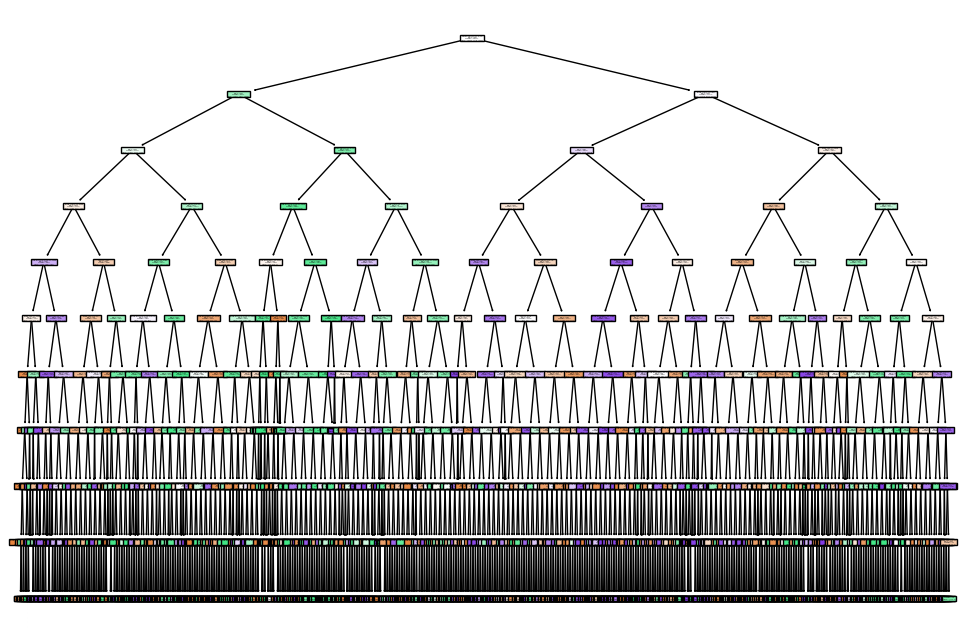

In [17]:
# decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

dt_model=DecisionTreeClassifier(max_depth=10,random_state=42).fit(x_train,y_train)
y_pred=ct_model.predict(x_test)
dt_accuracy=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average="weighted")
print("Accuracy:", dt_accuracy)
print("F1 Score: %.2f" % f1)
feature_names = df.drop(["Injury Severity"],axis=1).columns
fig,ax = plt.subplots(figsize=(12, 8))
tree.plot_tree(dt_model, feature_names=feature_names, filled=True, ax=ax)

plt.show()

# This works perfectly so far. Not over or under fitting. 


In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

information_gain = mutual_info_classif(x_train, y_train)
# Normalize Information Gain to obtain Gain Ratio
sum_information_gain = np.sum(information_gain)
gain_ratio = information_gain / sum_information_gain

for feature, ig, gr in zip(feature_names, information_gain, gain_ratio):
    print(f"{feature}:")
    print(f"   Information Gain: {ig}")
    print(f"   Gain Ratio: {gr}")
    print()

# Information Gain: is a metric used to measure the reduction in entropy or impurity when a specific feature is 
# used for splitting the data in a decision tree. A higher information gain indicates that the feature is more 
# informative and contributes more to the decision-making process.
# Gain Ratio: is another evaluation metric that takes into account the intrinsic information of the feature, in 
# addition to information gain. It helps to handle the bias towards attributes with a large number of distinct 
# values. A higher gain ratio suggests that the feature is more valuable for splitting the data

# Surface Condition:
#   Information Gain: 0.13563905191524994
#   Gain Ratio: 0.2898707704019574

Route Type:
   Information Gain: 0.022812994566997924
   Gain Ratio: 0.048753498747160895

Collision Type:
   Information Gain: 0.03578846075209352
   Gain Ratio: 0.07648328111049987

Weather:
   Information Gain: 0.02926217568224998
   Gain Ratio: 0.06253600075492037

Surface Condition:
   Information Gain: 0.1356380095465175
   Gain Ratio: 0.2898710868085633

Light:
   Information Gain: 0.03399071258047126
   Gain Ratio: 0.072641325466514

Traffic Control:
   Information Gain: 0.011387908031091243
   Gain Ratio: 0.024337022406070385

Driver Substance Abuse:
   Information Gain: 0.038438019332103224
   Gain Ratio: 0.08214563510491592

Driver At Fault:
   Information Gain: 0.0749793017396212
   Gain Ratio: 0.16023776636118608

Driver Distracted By:
   Information Gain: 0.026444412982117083
   Gain Ratio: 0.05651417885568323

Speed Limit:
   Information Gain: 0.033041959553412825
   Gain Ratio: 0.07061375169139143

Day of Week:
   Information Gain: 0.019538284429957198
   Gain Ratio: 0.

In [11]:
# gradient boosting algorithm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb_model=GradientBoostingClassifier(random_state=42).fit(x_train,y_train)
y_pred=gb_model.predict(x_test)
gb_accuracy=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,average="weighted")
print("Accuracy:", gb_accuracy)
print("F1 Score: %.2f" % f1)

# This was not mentioned during the class. 
# However, gradient boosting algorithm are used 4 out of 6 journals 
# from the literature review section. 
# We decided to use this and the performance seems reasonable so far. 
# However, this algorithm is quite resource consuming. 
# Also, it takes a very long time to finish.


Accuracy: 0.8136919898283534
F1 Score: 0.81


In [ ]:
# Comparative analysis of the models 

# Logistic Regression 
# It is a statistical algorithm that is used for modelling the relationship between a dependent variable and 
# independent variables. It estimates the probabilities of the different outcomes using a logistic function
# It assumes a linear relationship between features and class attribute.
# It can handle both binary and multi-class classification problems.
# Strengths:
#   Efficient and fast training and prediction.
#   Good performance on datasets with linearly separable classes.
# Weaknesses:
#   Limited in handling complex interactions between features.
#   Assumes a linear relationship.

# Naive Bayes
# It is a simple and straightforward probabilistic algorithm based on Bayes' theorem, which calculates the 
# conditional probability of a class given independent variables, assuming independence among independent variables. 
# Strengths:
#   Fast training and prediction. 
#   Handles high-dimensional and sparse data well.
#   Good performance with categorical and text data.
#   Works well with small training datasets.
# Weaknesses:
#   Strong assumption of independence between features.
#   cannot effectively capture complex interactions or feature dependencies.
#   Does not handle missing data inherently.

# KNN 
# It is a non-parametric and instance-based algorithm that used for both classification and regression tasks.
# It classifies new instances based on the majority vote of its k nearest neighbors in the feature space.
# Can handle both classification and regression tasks.
# Strengths:
#   Simple and easy to understand and implement.
#   Handles multi-class classification naturally.
#   Can capture complex decision boundaries.
# Weaknesses:
#   Computationally expensive during prediction, especially with large datasets.
#   Sensitive to the choice of k and the distance metric.

# Decision Tree 
# It is a hierarchical tree-based algorithm that makes decisions or predictions by following a tree-like 
# structure of conditional rules based on the features of the input data.
# Strengths:
#   Easy to understand and interpret, especially when visualized
#   Can capture non-linear relationships and interactions between features.
#   Can handle both categorical and numerical features
#   Can handle missing values by making decisions based on available features
# Weaknesses:
#   Can be prone to over-fitting if not properly controlled.
#   Can be sensitive, as small changes in data can result in different trees.

# Gradient Boosting Algorithm
# It combines multiple weak learners to create a strong predictive model.
# It aims to iteratively improve the model's performance by minimizing the errors or residuals of the previous 
# iterations.
# Can handle both regression and classification tasks.
# Strengths:
#   Excellent predictive performance and accuracy.
#   Can capture complex complex relationships and interactions between features.
#   Handles a variety of data types and can accommodate missing values.
# Weaknesses:
#   Computationally expensive and can be time-consuming to train due to the iterative nature.
#   Prone to over-fitting if the number of iterations is too high or the base learners are too complex.
#   Requires careful parameter tuning and monitoring to prevent over-fitting.
#   Less interpretable compared to simple models like logistic regression or decision trees.

# overall, all those algorithms are trained with the same dataset and same experimental design,
# based on the outputs(accuracy and F1 score), KNN achieves the highest accuracy and F1 score, indicating its 
# strong performance.
# Decision Tree and Gradient Boosting show relatively good performance with accuracy and F1 scores above 0.80.
# Logistic Regression and Naive Bayes have lower accuracy and F1 scores compared to the other algorithms, but 
# they can still provide reasonable results.
